In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
import time
import warnings
warnings.filterwarnings("ignore")

# Load MovieLens Data

In [2]:
movie=pd.read_csv('ml-1m/movies.dat', sep=r'::', engine='python', header=None).rename(columns={0:'movieId',1:'title',2:'genres'})
movie

,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [3]:
df=pd.read_csv('ml-latest/links.csv')
df

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
86532,288967,14418234,845861.0
86533,288971,11162178,878958.0
86534,288975,70199,150392.0
86535,288977,23050520,1102551.0


In [4]:
movie=movie.merge(df, how='left', on='movieId')
movie.to_csv('movie_with_link.csv')
movie

,movieId,title,genres,imdbId,tmdbId
0,1,Toy Story (1995),Animation|Children's|Comedy,114709.0,862.0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,113497.0,8844.0
2,3,Grumpier Old Men (1995),Comedy|Romance,113228.0,15602.0
3,4,Waiting to Exhale (1995),Comedy|Drama,114885.0,31357.0
4,5,Father of the Bride Part II (1995),Comedy,113041.0,11862.0
...,...,...,...,...,...
3878,3948,Meet the Parents (2000),Comedy,212338.0,1597.0
3879,3949,Requiem for a Dream (2000),Drama,180093.0,641.0
3880,3950,Tigerland (2000),Drama,170691.0,10687.0
3881,3951,Two Family House (2000),Drama,202641.0,63956.0


In [5]:
def movie_info_tmdb(tmdbId):
    url = 'https://www.themoviedb.org/movie/'+str(int(tmdbId))
    print(url)
    
    values={'tmdbId':tmdbId}
    try:
        response = requests.get(url)
        if response.status_code == 200:
            result = BeautifulSoup(response.content,'lxml')
        else:
            print(response.status_code)
            print('can\'t get attributes for movie:', str(int(tmdbId)),' because of failed request') 
        
        # Get Director
        try:
            for tag in result.find_all('li',class_="profile"):
                text=tag.get_text().strip().splitlines()
                if 'Director' in text[1]:
                    values['Director'] = text[0]
                    break
        except:
            values['Director'] = ''
            
        # Get Stars
        try:
            stars = []
            for tag in result.find_all('li',class_="card"):
                href = tag.find('a',href=True).get('href')
                if href:
                    end_position = re.search(r'\d+-', href).end()
                    stars.append(href[end_position:].replace('-',' '))

            values['Stars'] = stars
        except:
            values['Stars'] = []
        
        #Get Original Language and Revenue
        values['Original Language'] = ''
        values['Revenue'] = ''
        try:
            for tag in result.find_all('section',class_="facts left_column"):
                if tag.get_text().strip():
                    attrs = tag.get_text().strip().splitlines()
            for attr in attrs:
                if 'Original Language' in attr:
                    values['Original Language'] = attr.split(' ')[-1]
                if 'Revenue' in attr:
                    values['Revenue'] = attr.split(' ')[-1]
        except:
            pass
            
        # Get Keywords
        values['Keywords'] = []
        try:
            for tag in result.find_all('section',class_="keywords right_column"):
                raw_keywords=tag.get_text().splitlines()
            for keyword in raw_keywords:
                if keyword!='' and keyword!='Keywords':
                    values['Keywords'].append(keyword)
        except:
            pass
        
        return values

    except:
        print('can\'t get attributes for movie:', str(int(tmdbId))) 

In [6]:
print(movie['tmdbId'].iloc[4])
ret = movie_info_tmdb(movie['tmdbId'].iloc[4])
pd.DataFrame.from_dict(ret, orient='index').transpose()

11862.0
https://www.themoviedb.org/movie/11862


,tmdbId,Director,Stars,Original Language,Revenue,Keywords
0,11862,Charles Shyer,"[steve martin, diane keaton, martin short, kim...",English,"$76,594,107.00","[parent child relationship, baby, midlife cris..."


In [ ]:
#movie_attrs = []
for i in range(len(movie)):
    print(i,movie['title'].iloc[i],movie['tmdbId'].iloc[i])
    if not pd.isnull(movie['tmdbId'].iloc[i]):
        value = movie_info_tmdb(movie['tmdbId'].iloc[i])
        movie_attrs.append(value)
        time.sleep(1)

In [ ]:
attrs=[]
for movie_attr in movie_attrs:
    if movie_attr:
        attrs.append(movie_attr)

In [ ]:
pd.DataFrame(attrs).to_csv('movie_with_attributes.csv')

# Import Movie Attributes Data

In [7]:
movies = pd.read_csv("movie_with_attributes.csv")
movies.head()

,movieId,title,genres,imdbId,tmdbId,Release_Year,Director,Stars,Original Language,Revenue,Keywords
0,1,Toy Story (1995),Animation|Children's|Comedy,114709.0,862.0,1995,John Lasseter,"['tom hanks', 'tim allen', 'don rickles', 'jim...",English,394436586,"['jealousy', 'villain', 'friendship', 'bullyin..."
1,2,Jumanji (1995),Adventure|Children's|Fantasy,113497.0,8844.0,1995,Joe Johnston,"['robin williams', 'kirsten dunst', 'bradley p...",English,262821940,"['giant insect', 'board game', 'jungle', 'disa..."
2,3,Grumpier Old Men (1995),Comedy|Romance,113228.0,15602.0,1995,Howard Deutch,"['walter matthau', 'jack lemmon', 'ann margret...",English,71500000,"['fishing', 'sequel', 'old man', 'best friend'..."
3,4,Waiting to Exhale (1995),Comedy|Drama,114885.0,31357.0,1995,Forest Whitaker,"['whitney houston', 'angela bassett', 'loretta...",English,81452156,"['based on novel or book', 'interracial relati..."
4,5,Father of the Bride Part II (1995),Comedy,113041.0,11862.0,1995,Charles Shyer,"['steve martin', 'diane keaton', 'martin short...",English,76594107,"['parent child relationship', 'baby', 'midlife..."


In [8]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movieId            3883 non-null   int64  
 1   title              3883 non-null   object 
 2   genres             3883 non-null   object 
 3   imdbId             3850 non-null   float64
 4   tmdbId             3832 non-null   float64
 5   Release_Year       3883 non-null   int64  
 6   Director           3828 non-null   object 
 7   Stars              3735 non-null   object 
 8   Original Language  3831 non-null   object 
 9   Revenue            2427 non-null   object 
 10  Keywords           3513 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 333.8+ KB


# Check Null Values

In [9]:
# 51 movies don't have tmdbID:
# 55 movies are without director info
# 148 movies are without stars (actors) info
# 52 movies are without original Language info
# 1456 movies are without revenue info
# 370 movies are without keywords info
movies.isnull().sum()

movieId                 0
title                   0
genres                  0
imdbId                 33
tmdbId                 51
Release_Year            0
Director               55
Stars                 148
Original Language      52
Revenue              1456
Keywords              370
dtype: int64

# Remove Unnecessary Columns And Nulls

In [10]:
movies=movies[['movieId','title','genres','Release_Year','Director','Stars','Original Language','Keywords']].dropna()

In [11]:
# convert genre to list
movies['genres'] = movies['genres'].str.split('|')

In [12]:
# convert stars to list
movies['Stars'] = movies['Stars'].str.strip("[]").str.replace("'",'').str.split(', ')

In [13]:
# convert keywords to list
movies['Keywords'] = movies['Keywords'].str.strip("[]").str.replace("'",'').str.split(', ')

In [14]:
movies.isnull().sum()

movieId              0
title                0
genres               0
Release_Year         0
Director             0
Stars                0
Original Language    0
Keywords             0
dtype: int64

In [15]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3435 entries, 0 to 3882
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   movieId            3435 non-null   int64 
 1   title              3435 non-null   object
 2   genres             3435 non-null   object
 3   Release_Year       3435 non-null   int64 
 4   Director           3435 non-null   object
 5   Stars              3435 non-null   object
 6   Original Language  3435 non-null   object
 7   Keywords           3435 non-null   object
dtypes: int64(2), object(6)
memory usage: 241.5+ KB


In [16]:
movies

,movieId,title,genres,Release_Year,Director,Stars,Original Language,Keywords
0,1,Toy Story (1995),"[Animation, Children's, Comedy]",1995,John Lasseter,"[tom hanks, tim allen, don rickles, jim varney...",English,"[jealousy, villain, friendship, bullying, elem..."
1,2,Jumanji (1995),"[Adventure, Children's, Fantasy]",1995,Joe Johnston,"[robin williams, kirsten dunst, bradley pierce...",English,"[giant insect, board game, jungle, disappearan..."
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",1995,Howard Deutch,"[walter matthau, jack lemmon, ann margret, sop...",English,"[fishing, sequel, old man, best friend, weddin..."
3,4,Waiting to Exhale (1995),"[Comedy, Drama]",1995,Forest Whitaker,"[whitney houston, angela bassett, loretta devi...",English,"[based on novel or book, interracial relations..."
4,5,Father of the Bride Part II (1995),[Comedy],1995,Charles Shyer,"[steve martin, diane keaton, martin short, kim...",English,"[parent child relationship, baby, midlife cris..."
...,...,...,...,...,...,...,...,...
3877,3947,Get Carter (1971),[Thriller],1971,Mike Hodges,"[michael caine, ian hendry, britt ekland, john...",English,"[pornography, loss of loved one, hitman, gangs..."
3878,3948,Meet the Parents (2000),[Comedy],2000,Jay Roach,"[ben stiller, robert de niro, teri polo, blyth...",English,"[nurse, central intelligence agency (cia), air..."
3879,3949,Requiem for a Dream (2000),[Drama],2000,Darren Aronofsky,"[ellen burstyn, jared leto, jennifer connelly,...",English,"[corruption, drug abuse, drug addiction, drug ..."
3880,3950,Tigerland (2000),[Drama],2000,Joel Schumacher,"[colin farrell, matthew davis, clifton collins...",English,"[1970s, louisiana, kansas, usa, guitar player,..."


# Data Visualization

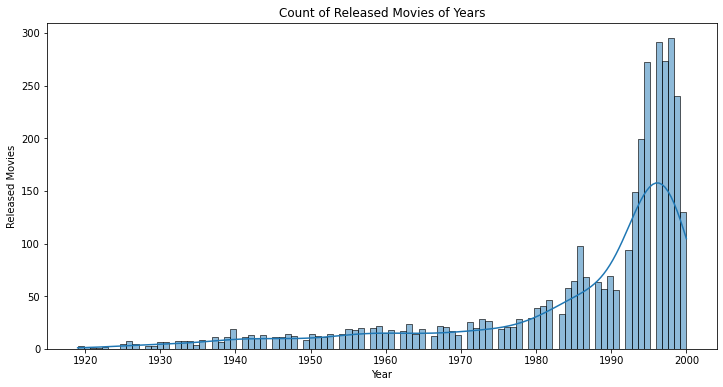

In [17]:
plt.figure(figsize=(12, 6))
sns.histplot(x='Release_Year',bins=100, data = movies, kde=True)
plt.title(f'Count of Released Movies of Years')
plt.xlabel('Year')
plt.ylabel('Released Movies')
plt.show()

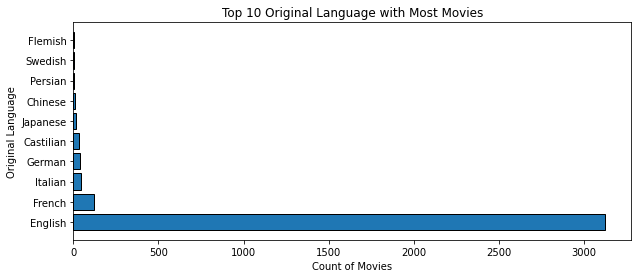

In [18]:
plt.figure(figsize=(10, 4))
langs =pd.DataFrame(movies.groupby('Original Language')['movieId'].count().sort_values(ascending=False).head(10)).reset_index()
plt.barh(langs['Original Language'], langs['movieId'], edgecolor='black')
plt.title('Top 10 Original Language with Most Movies')
plt.xlabel('Count of Movies')
plt.ylabel('Original Language')
plt.show()

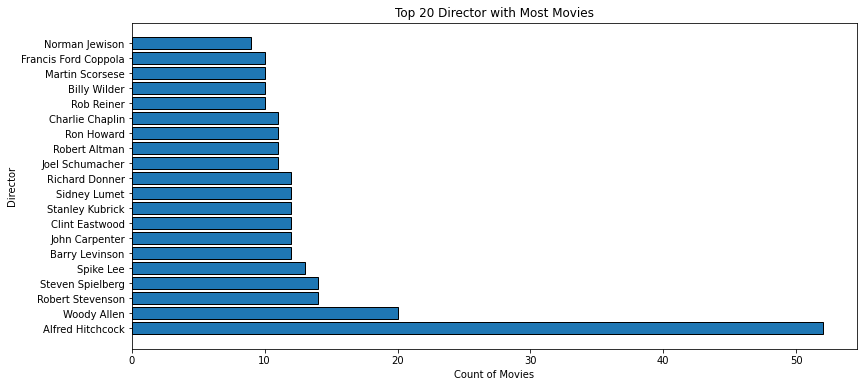

In [19]:
plt.figure(figsize=(13, 6))
dirs =pd.DataFrame(movies.groupby('Director')['movieId'].count().sort_values(ascending=False).head(20)).reset_index()
plt.barh(dirs['Director'], dirs['movieId'], edgecolor='black')
plt.title('Top 20 Director with Most Movies')
plt.xlabel('Count of Movies')
plt.ylabel('Director')
plt.show()

In [20]:
stars = {}
for i in range(len(movies)):
    for star in movies['Stars'].iloc[i]:
        if star in stars.keys():
            stars[star]['Movies'] += 1
        else:
            stars[star] = {'Movies':1}


stars = pd.DataFrame.from_dict(stars, orient='index')
stars = stars.reset_index().rename(columns={"index": "Star"})
stars

,Star,Movies
0,a bailey chapin,1
1,a j cook,1
2,a j johnson,2
3,a j langer,2
4,a l camp,1
...,...,...
15002,zorie barber,1
15003,zorka manojlovic,1
15004,zozo toledo,1
15005,zvee scooler,1


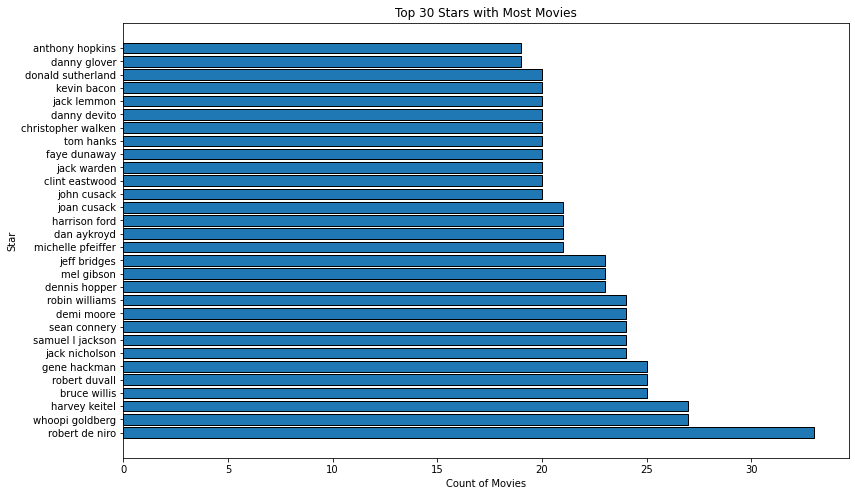

In [21]:
plt.figure(figsize=(13, 8))
star_movies = stars.sort_values(by='Movies', ascending=False).head(30)
plt.barh(star_movies['Star'], star_movies['Movies'], edgecolor='black')
plt.title('Top 30 Stars with Most Movies')
plt.xlabel('Count of Movies')
plt.ylabel('Star')
plt.show()

In [22]:
genres = {}
for i in range(len(movies)):
    for genre in movies['genres'].iloc[i]:
        if genre in genres.keys():
            genres[genre]['Movies'] += 1
        else:
            genres[genre] = {'Movies':1}

genres = pd.DataFrame.from_dict(genres, orient='index')
genres = genres.reset_index().rename(columns={"index": "Genre"})
genres

,Genre,Movies
0,Action,465
1,Adventure,265
2,Animation,94
3,Children's,237
4,Comedy,1070
5,Crime,200
6,Documentary,74
7,Drama,1391
8,Fantasy,66
9,Film-Noir,44


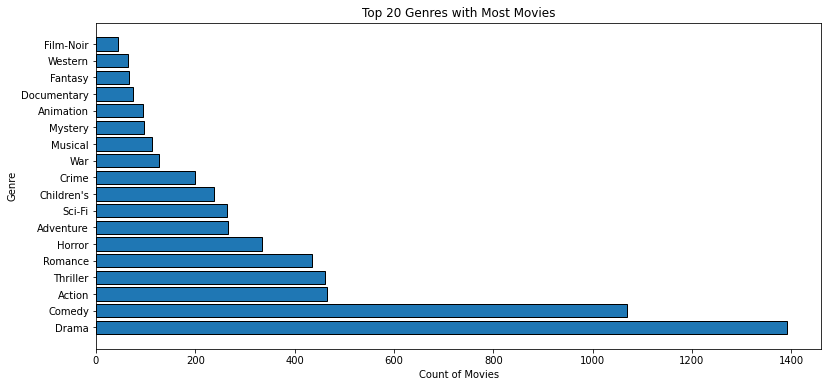

In [23]:
plt.figure(figsize=(13, 6))
genres_movies = genres.sort_values(by='Movies', ascending=False).head(20)
plt.barh(genres_movies['Genre'], genres_movies['Movies'], edgecolor='black')
plt.title('Top 20 Genres with Most Movies')
plt.xlabel('Count of Movies')
plt.ylabel('Genre')
plt.show()

In [24]:
keywords = {}
for i in range(len(movies)):
    for keyword in movies['Keywords'].iloc[i]:
        if keyword in keywords.keys():
            keywords[keyword]['Movies'] += 1
        else:
            keywords[keyword] = {'Movies':1}

keywords = pd.DataFrame.from_dict(keywords, orient='index')
keywords = keywords.reset_index().rename(columns={"index": "Keywords"})
keywords

,Keywords,Movies
0,"""a bugs life""",1
1,"""alzheimers disease""",2
2,"""ants nest""",1
3,"""april fools day""",1
4,"""artists life""",3
...,...,...
9395,đavo,1
9396,勇敢的心,1
9397,살인,1
9398,스릴러,1


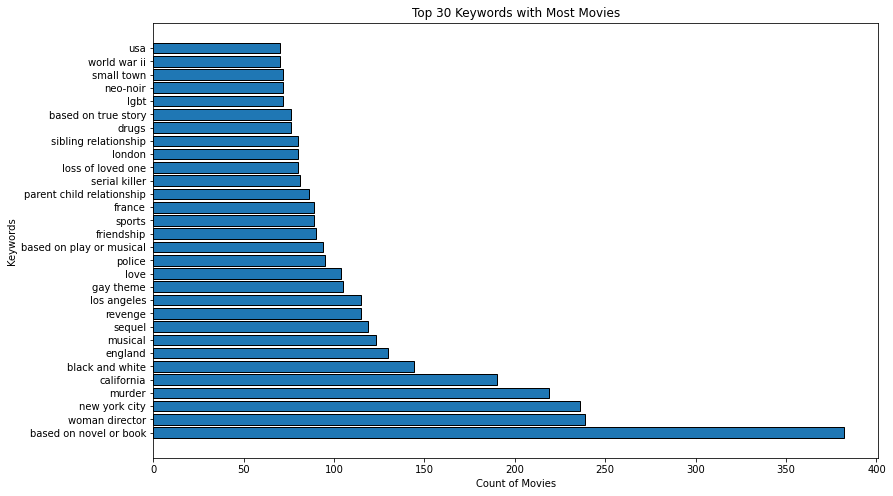

In [25]:
plt.figure(figsize=(13, 8))
keywords_movies = keywords.sort_values(by='Movies', ascending=False).head(30)
plt.barh(keywords_movies['Keywords'], keywords_movies['Movies'], edgecolor='black')
plt.title('Top 30 Keywords with Most Movies')
plt.xlabel('Count of Movies')
plt.ylabel('Keywords')
plt.show()

# Convert Categorical Features to Dummy Variables

In [26]:
#convert top 10 original language
def convert_language(language):
    if language in list(langs['Original Language']):
        return language
    else:
        return 'others'

movies['Language'] = movies['Original Language'].apply(lambda x: convert_language(x))
movies = pd.get_dummies(movies, columns=['Language'], drop_first=False)

In [27]:
#convert top 20 Director
def convert_director(director):
    if director in list(dirs['Director']):
        return director
    else:
        return 'others'

movies['director'] = movies['Director'].apply(lambda x: convert_director(x))
movies = pd.get_dummies(movies, columns=['director'], drop_first=False)

In [28]:
#convert top 10 genres
for top_genre in list(genres_movies['Genre'])[:10]:
    movies['Genre_'+top_genre] = False
    
for i in range(len(movies)):
    for genre in movies['genres'].iloc[i]:
        if genre in list(genres_movies['Genre'])[:10]:
            movies['Genre_'+genre].iloc[i] = True

In [29]:
#convert top 20 stars
for top_star in list(star_movies['Star'])[:20]:
    movies['Star_'+top_star] = False
    
for i in range(len(movies)):
    for star in movies['Stars'].iloc[i]:
        if star in list(star_movies['Star'])[:20]:
            movies['Star_'+star].iloc[i] = True

In [30]:
#convert top 20 keywords
for top_keyword in list(keywords_movies['Keywords'])[:20]:
    movies['Keyword_'+top_keyword] = False
    
for i in range(len(movies)):
    for keyword in movies['Keywords'].iloc[i]:
        if keyword in list(keywords_movies['Keywords'])[:20]:
            movies['Keyword_'+keyword].iloc[i] = True

In [31]:
# Drop UserID and original Zip-code columns
movies = movies.drop(columns=['Original Language','genres', 'Director', 'Stars', 'Keywords'])
movies

,movieId,title,Release_Year,Language_Castilian,Language_Chinese,Language_English,Language_Flemish,Language_French,Language_German,Language_Italian,...,Keyword_los angeles,Keyword_gay theme,Keyword_love,Keyword_police,Keyword_based on play or musical,Keyword_friendship,Keyword_sports,Keyword_france,Keyword_parent child relationship,Keyword_serial killer
0,1,Toy Story (1995),1995,0,0,1,0,0,0,0,...,False,False,False,False,False,True,False,False,False,False
1,2,Jumanji (1995),1995,0,0,1,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
2,3,Grumpier Old Men (1995),1995,0,0,1,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
3,4,Waiting to Exhale (1995),1995,0,0,1,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
4,5,Father of the Bride Part II (1995),1995,0,0,1,0,0,0,0,...,True,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3877,3947,Get Carter (1971),1971,0,0,1,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
3878,3948,Meet the Parents (2000),2000,0,0,1,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
3879,3949,Requiem for a Dream (2000),2000,0,0,1,0,0,0,0,...,False,True,False,False,False,False,False,False,False,False
3880,3950,Tigerland (2000),2000,0,0,1,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False


In [32]:
movies.columns

Index(['movieId', 'title', 'Release_Year', 'Language_Castilian',
       'Language_Chinese', 'Language_English', 'Language_Flemish',
       'Language_French', 'Language_German', 'Language_Italian',
       'Language_Japanese', 'Language_Persian', 'Language_Swedish',
       'Language_others', 'director_Alfred Hitchcock',
       'director_Barry Levinson', 'director_Billy Wilder',
       'director_Charlie Chaplin', 'director_Clint Eastwood',
       'director_Francis Ford Coppola', 'director_Joel Schumacher',
       'director_John Carpenter', 'director_Martin Scorsese',
       'director_Norman Jewison', 'director_Richard Donner',
       'director_Rob Reiner', 'director_Robert Altman',
       'director_Robert Stevenson', 'director_Ron Howard',
       'director_Sidney Lumet', 'director_Spike Lee',
       'director_Stanley Kubrick', 'director_Steven Spielberg',
       'director_Woody Allen', 'director_others', 'Genre_Drama',
       'Genre_Comedy', 'Genre_Action', 'Genre_Thriller', 'Genre_Romanc

In [33]:
movies.to_csv('cleaned_movies.csv')